In [89]:
import os
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [90]:
import sys
if not os.path.exists("Pointnet_Pointnet2_pytorch"):
    !git clone https://github.com/yanx27/Pointnet_Pointnet2_pytorch.git Pointnet_Pointnet2_pytorch
repo_path = "./Pointnet_Pointnet2_pytorch"  
sys.path.append(os.path.abspath(repo_path))
sys.path.append(os.path.abspath(os.path.join(repo_path, "models")))


In [91]:
objects_path = os.path.join('.', 'sydney-urban-objects-dataset/sydney-urban-objects-dataset', 'objects')

print("Objects path is:", objects_path)
print("Contents of 'objects':", os.listdir(objects_path))


Objects path is: .\sydney-urban-objects-dataset/sydney-urban-objects-dataset\objects
Contents of 'objects': ['4wd.0.2299.bin', '4wd.0.2299.bin.meta', '4wd.0.2299.csv', '4wd.1.2446.bin', '4wd.1.2446.bin.meta', '4wd.1.2446.csv', '4wd.10.17589.bin', '4wd.10.17589.bin.meta', '4wd.10.17589.csv', '4wd.11.6994.bin', '4wd.11.6994.bin.meta', '4wd.11.6994.csv', '4wd.12.3582.bin', '4wd.12.3582.bin.meta', '4wd.12.3582.csv', '4wd.13.270.bin', '4wd.13.270.bin.meta', '4wd.13.270.csv', '4wd.14.5229.bin', '4wd.14.5229.bin.meta', '4wd.14.5229.csv', '4wd.15.5563.bin', '4wd.15.5563.bin.meta', '4wd.15.5563.csv', '4wd.16.6123.bin', '4wd.16.6123.bin.meta', '4wd.16.6123.csv', '4wd.17.6783.bin', '4wd.17.6783.bin.meta', '4wd.17.6783.csv', '4wd.18.7288.bin', '4wd.18.7288.bin.meta', '4wd.18.7288.csv', '4wd.19.10974.bin', '4wd.19.10974.bin.meta', '4wd.19.10974.csv', '4wd.2.3582.bin', '4wd.2.3582.bin.meta', '4wd.2.3582.csv', '4wd.20.12346.bin', '4wd.20.12346.bin.meta', '4wd.20.12346.csv', '4wd.3.4043.bin', '4wd.3.4

In [92]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)

In [93]:
def read_bin(file_name):
    names   = ['t','intensity','id','x','y','z','azimuth','range','pid']
    formats = ['int64','uint8','uint8',
               'float32','float32','float32',
               'float32','float32','int32']

    binType = np.dtype(dict(names=names, formats=formats))
    data = np.fromfile(file_name, binType)

    # 3D points, one per row:
    P = np.vstack((data['x'], data['y'], data['z'])).T
    return P


In [94]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis=1)
    chosen = random.choices(res1, k=k)  
    chosen = np.asarray(chosen)
    
    pcs_out = chosen[:, :-1]
    labels_out = chosen[:, -1]
    return pcs_out, labels_out

In [95]:
def farthest_point_sample(points, n_samples):
    """
    points: numpy array of shape (N, 3)
    n_samples: number of points to sample
    returns: indices of the selected points of shape (n_samples,)
    """
    N, _ = points.shape
    if n_samples >= N:
        extra = np.random.choice(N, n_samples - N, replace=True)
        return np.concatenate([np.arange(N), extra])
    
    centroids = np.zeros((n_samples,), dtype=np.int64)
    distances = np.full((N,), np.inf)
    farthest = np.random.randint(0, N)
    
    for i in range(n_samples):
        centroids[i] = farthest
        centroid = points[farthest, :]  # shape (3,)
        dist = np.sum((points - centroid) ** 2, axis=1)
        distances = np.minimum(distances, dist)
        farthest = np.argmax(distances)
    return centroids

In [96]:
class SydneyUrban(Dataset):
    def __init__(self, file_paths, labels, num_points=2048, transform=False):
        self.files = file_paths
        self.labels = labels
        self.num_points = num_points
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        pts = read_bin(self.files[idx])
        label = self.labels[idx]
        
        # Apply data augmentation if enabled using 'pts'
        if self.transform:
            pts = self.random_rotation_z(pts)
            pts = self.random_scaling(pts)
            pts = self.random_jitter(pts)
        
        # Use farthest point sampling on the xyz coordinates
        if pts.shape[0] > self.num_points:
            fps_idxs = farthest_point_sample(pts[:, :3], self.num_points)
            points = pts[fps_idxs]
        else:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=True)
            points = pts[idxs]
        
        # Normalize the points (only x,y,z coordinates)
        points[:, :3] = self.normalize(points[:, :3])
        
        points = torch.from_numpy(points).float()
        label = torch.tensor(label).long()
        
        return points, label
        
    def normalize(self, points):
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(points ** 2, axis=1)))
        points /= furthest_distance
        return points
    
    def random_rotation_z(self, pts):
        theta = np.random.uniform(0, 2 * np.pi)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [0,              0,             1]
        ], dtype=np.float32)
        pts[:, :3] = pts[:, :3].dot(rotation_matrix)
        return pts
    
    def random_scaling(self, pts, scale_low=0.9, scale_high=1.1):
        scale = np.random.uniform(scale_low, scale_high)
        pts[:, :3] *= scale
        return pts
    
    def random_jitter(self, pts, sigma=0.01, clip=0.05):
        jitter = np.clip(sigma * np.random.randn(pts.shape[0], 3), -clip, clip)
        pts[:, :3] += jitter
        return pts

In [97]:
all_files = [
    os.path.join(objects_path,f)
    for f in os.listdir(objects_path)
    if f.endswith('.bin') and not f.endswith('.bin.meta')
    ]

all_labels = []
for f in all_files:
    file_name = os.path.basename(f)
    label_str = file_name.split('.')[0]
    num_label = labels_dict[label_str]
    all_labels.append(num_label)

In [98]:
len(all_files), len(all_labels)

(631, 631)

In [99]:
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42) 

In [100]:
train_dataset = SydneyUrban(train_files, train_labels, num_points=2048, transform=True)
test_dataset = SydneyUrban(test_files, test_labels, num_points=2048, transform=False)

In [101]:
len(train_dataset), len(test_dataset)

(504, 127)

#### Visualize the dataset

In [102]:
reverse_labels = {v: k for k, v in labels_dict.items()}

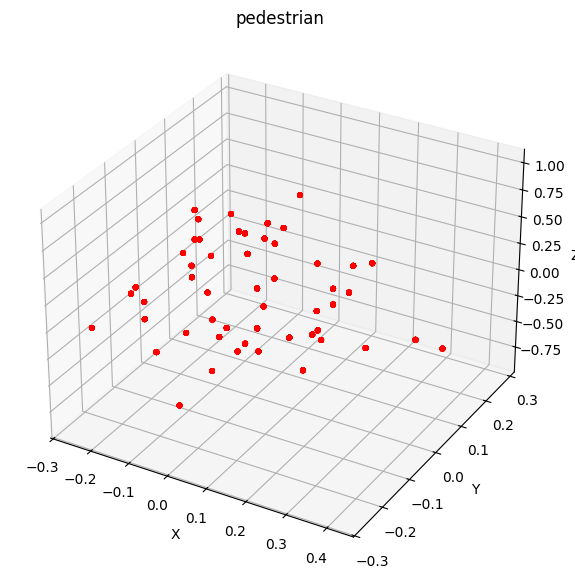

Class: pedestrian


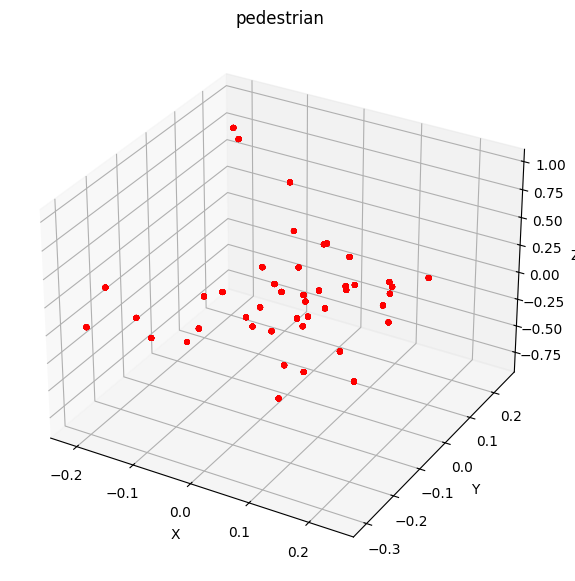

Class: pedestrian


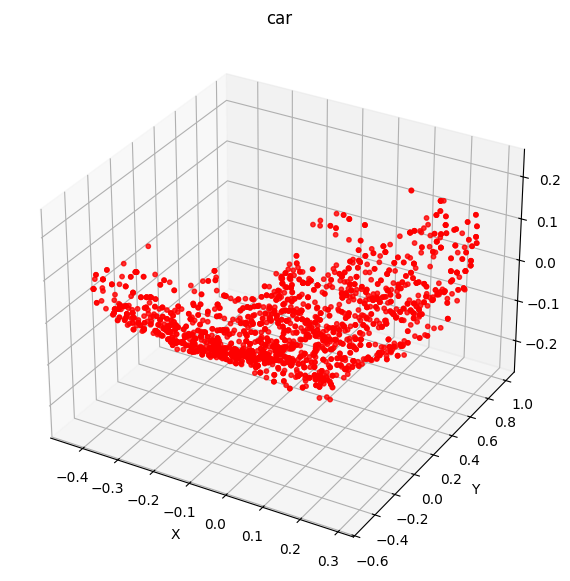

Class: car


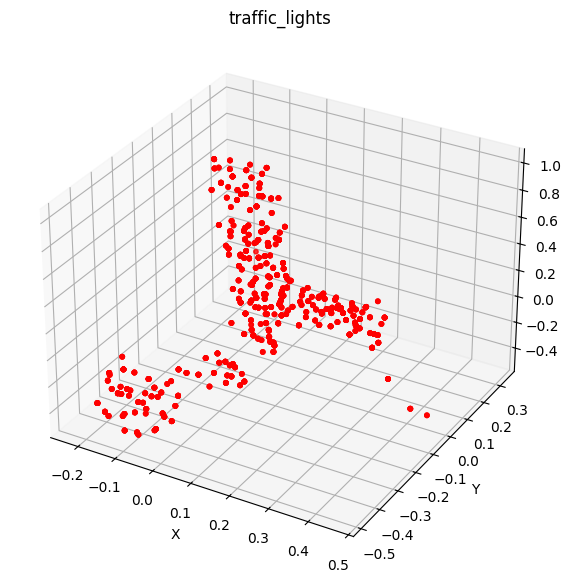

Class: traffic_lights


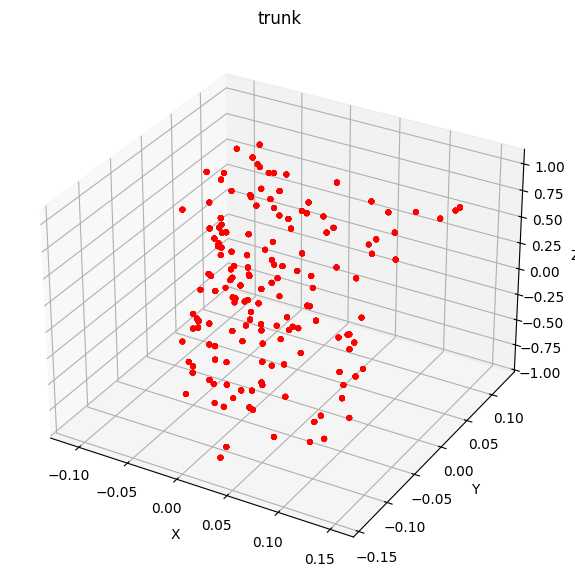

Class: trunk


In [103]:
def plot_pc(points, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# visualize 5 samples
for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    points = sample[0].numpy()
    label = sample[1].item()
    class_name = reverse_labels[label]
    
    plot_pc(points, class_name)
    print(f"Class: {class_name}")
    

In [104]:
from models.pointnet2_cls_ssg import get_model

model = get_model(num_class=num_classes, normal_channel=False)  
model = model.cuda()
model

get_model(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(131, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNetSetAbstract

In [105]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

epoch_losses = []
epoch_accuracies = []

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for pc_batch, label_batch in train_loader:
        pc_batch = pc_batch.permute(0, 2, 1)
        pc_batch = pc_batch.cuda()
        label_batch = label_batch.cuda()
        
        optimizer.zero_grad()
        logits,_ = model(pc_batch)
        loss = criterion(logits, label_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * pc_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset) 
    epoch_losses.append(epoch_loss)   
    print(f"Epoch {epoch+1}, Loss {loss.item()}")
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for pc_batch, label_batch in test_loader:
            pc_batch = pc_batch.permute(0, 2, 1)
            pc_batch = pc_batch.cuda()
            label_batch = label_batch.cuda()
            
            logits,_ = model(pc_batch)
            _, predicted = torch.max(logits, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
            
    accuracy = correct / total
    epoch_accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}")
        
            

Epoch 1, Loss 1.7938276529312134
Accuracy: 0.05511811023622047
Epoch 2, Loss 1.7471109628677368
Accuracy: 0.047244094488188976
Epoch 3, Loss 1.6135683059692383
Accuracy: 0.10236220472440945
Epoch 4, Loss 1.7834056615829468
Accuracy: 0.3700787401574803
Epoch 5, Loss 1.3694902658462524
Accuracy: 0.6377952755905512
Epoch 6, Loss 1.214239478111267
Accuracy: 0.6377952755905512
Epoch 7, Loss 1.4850096702575684
Accuracy: 0.6456692913385826
Epoch 8, Loss 1.229820728302002
Accuracy: 0.6062992125984252
Epoch 9, Loss 1.1885221004486084
Accuracy: 0.6692913385826772
Epoch 10, Loss 1.2214468717575073
Accuracy: 0.6614173228346457
Epoch 11, Loss 1.0294532775878906
Accuracy: 0.7007874015748031
Epoch 12, Loss 1.0821118354797363
Accuracy: 0.6692913385826772
Epoch 13, Loss 1.0786007642745972
Accuracy: 0.6377952755905512
Epoch 14, Loss 1.0311607122421265
Accuracy: 0.6692913385826772
Epoch 15, Loss 0.8905640244483948
Accuracy: 0.7086614173228346
Epoch 16, Loss 0.7162392735481262
Accuracy: 0.5748031496062992

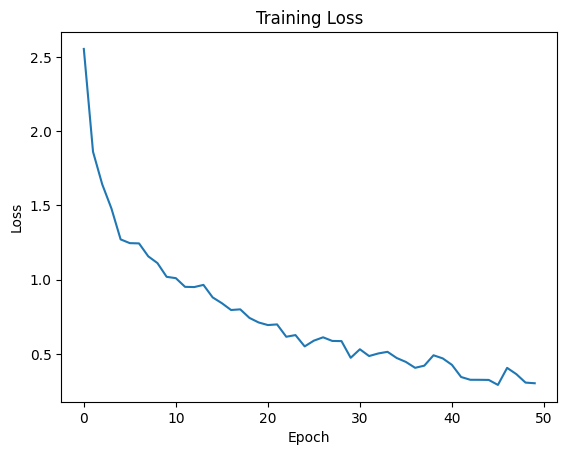

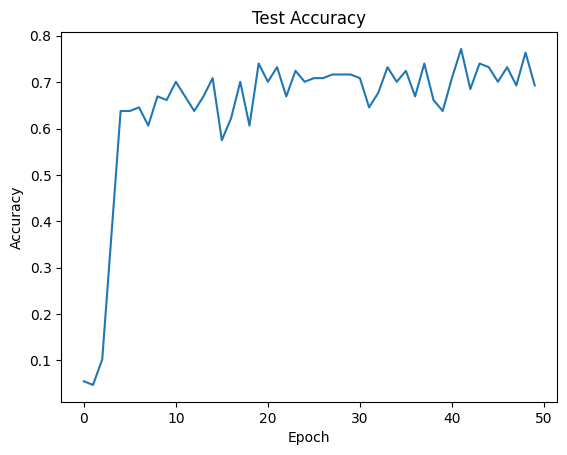

In [106]:
plt.figure()
plt.plot(epoch_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epoch_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()